<a href="https://colab.research.google.com/github/EdH66/CMAP-Analysis/blob/main/CMAP_Query_Ranking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connectivity Map and MPO Ranking

* CMAP_Predictions_Aggregatedlists.csv generated from DGE inputs to CMAP
* df_6k_curated_withMPO.csv taken from running MPO_automatic_calculator.ipynb

# Load and Import

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import pandas as pd
from sklearn.metrics import jaccard_score
import numpy as np

!pip install matplotlib


# Import data

In [23]:
# Read the CSV file
path_CMAP = '/content/drive/My Drive/Colab Notebooks/CMAP Drug Prediction/CMAP_Predictions_Aggregatedlists.csv'  # Replace with the URL of your CSV file
path_MPO = '/content/drive/My Drive/Colab Notebooks/CMAP Drug Prediction/df_6k_curated_withMPO.csv'
df_CMAP = pd.read_csv(path_CMAP)
df_MPO = pd.read_csv(path_MPO)


# Confirm data structure

In [24]:
print(df_CMAP.columns)
# Print the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(df_CMAP.head())

# Print the number of non-NA/null entries in each column
print("\nNumber of non-NA/null entries in each column:")
print(df_CMAP.count())


Index(['8 weeks', 'NCS', '12 weeks', 'NCS.1', '16 weeks', 'NCS.2', '18 weeks',
       'NCS.3', '20 weeks', 'NCS.4'],
      dtype='object')
First few rows of the DataFrame:
           8 weeks       NCS     12 weeks     NCS.1     16 weeks     NCS.2  \
0        alisertib -1.897671          IL1 -1.983262  BAY-87-2243 -1.942013   
1          XMD-132 -1.826331   GALR2_GALP -1.919355    estradiol -1.931010   
2  ketocholesterol -1.819495   entinostat -1.919287   aniracetam -1.879556   
3      ARRY-334543 -1.804553  importazole -1.899100   endo-IWR-1 -1.877958   
4       SA-1459830 -1.794416  clofarabine -1.893594      fenigam -1.864297   

        18 weeks     NCS.3       20 weeks     NCS.4  
0  BRD-K45319476 -1.474600  BRD-K47703442 -1.212188  
1  BRD-K17731272 -1.474600  BRD-K15950605 -1.183600  
2      I-BET-762 -1.474600  chelerythrine -1.183600  
3  BRD-K65730939 -1.455916    HG-14-10-04 -1.183600  
4    KIN-001-220 -1.437232      tiagabine -1.183600  

Number of non-NA/null entries in e

In [25]:
print(df_MPO.columns)
# Print the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(df_MPO.head())

# Print the number of non-NA/null entries in each column
print("\nNumber of non-NA/null entries in each column:")
print(df_MPO.count())

Index(['Calculated_MPO', 'ChEMBL ID', 'Drug', 'Phase', 'mw', 'logp', 'TSA',
       'HBA', 'HBD', 'Clogd', 'CX Acidic pKa', 'C_Basic pKa', 'CX LogP',
       '#RO5 Violations (Lipinski)', 'Targets', 'Bioactivities',
       '#RO5 Violations', '#Rotatable Bonds', 'Passes Ro3', 'QED Weighted',
       'Aromatic Rings', 'Structure Type', 'Inorganic Flag', 'Heavy Atoms',
       'HBA (Lipinski)', 'HBD (Lipinski)', 'Np Likeness Score',
       'Molecular Species', 'Molecular Formula', 'Smiles', 'Inchi Key',
       'Normalized_LogP', 'Normalized_CLogD', 'Normalized_Mol_Weight',
       'Normalized_TSA', 'Normalized_Hbond_Donor',
       'Normalized_Most_C_Basic pKa'],
      dtype='object')
First few rows of the DataFrame:
   Calculated_MPO      ChEMBL ID        Drug  Phase      mw  logp    TSA  HBA  \
0             6.0      CHEMBL934  METYRAPONE      4  226.28  2.64  42.85  3.0   
1             6.0  CHEMBL2105161   NICOBOXIL      3  223.27  2.06  48.42  4.0   
2             6.0      CHEMBL681   ETOM

# ANALYSE: Aggregate and ranking across groups

In [26]:
def find_compound_ranks(df_CMAP, list_cols, score_cols, compounds_to_find):
    # Exclude '18 weeks' if needed
    list_cols = [col for col in list_cols if col != '18 weeks']
    score_cols = [score for score in score_cols if score != 'NCS.3']

    # Filter out compounds starting with 'BRD'
    df_filtered = df_CMAP.copy()
    for col in list_cols:
        df_filtered[col] = df_filtered[col].astype(str)
        df_filtered = df_filtered[~df_filtered[col].str.startswith('BRD')]

    # Rank compounds within each list based on their NCS scores
    for col, score_col in zip(list_cols, score_cols):
        df_filtered[f'Rank_{score_col}'] = df_filtered[score_col].rank(ascending=False)

    # Identify compounds present in at least one of the lists
    compounds_in_lists = set(df_filtered[list_cols[0]].dropna())
    for col in list_cols[1:]:
        compounds_in_lists.update(set(df_filtered[col].dropna()))

    # Calculate average ranks for these compounds in each list
    compound_ranks = {compound: [] for compound in compounds_in_lists}
    for compound in compounds_in_lists:
        for col, rank_col in zip(list_cols, [f'Rank_{sc}' for sc in score_cols]):
            if compound in df_filtered[col].values:
                # Get all ranks of the compound in the list
                ranks = df_filtered[df_filtered[col] == compound][rank_col].tolist()
                if ranks:
                    avg_rank_in_list = sum(ranks) / len(ranks)
                    compound_ranks[compound].append(avg_rank_in_list)

    # Calculate overall average rank for each compound across lists
    overall_avg_ranks = {compound: sum(ranks) / len(ranks) if ranks else None
                         for compound, ranks in compound_ranks.items()}

    # Sort compounds by overall average rank in ascending order
    sorted_compounds = sorted(overall_avg_ranks.items(), key=lambda x: (x[1] is not None, x[1]), reverse=False)

    # Find the ranks of specific compounds
    ranks = {}
    for compound_to_find in compounds_to_find:
        rank = next((rank for rank, (comp, _) in enumerate(sorted_compounds, start=1) if comp == compound_to_find), None)
        ranks[compound_to_find] = rank

    return sorted_compounds, ranks

# Example usage
list_cols = ['8 weeks', '12 weeks', '16 weeks', '18 weeks', '20 weeks']
score_cols = ['NCS', 'NCS.1', 'NCS.2', 'NCS.3', 'NCS.4']
compounds_to_find = ['rosiglitazone', 'fluoxetine', 'alisertib', 'tomelukast', 'celastrol', 'pioglitazone', 'TWS-119', 'barasertib', 'clenbuterol', 'withaferin', 'metformin', 'trazodone']
ranked_compounds, ranks = find_compound_ranks(df_CMAP, list_cols, score_cols, compounds_to_find)

# Display the ranks of specific compounds
print("Ranks of specific compounds:")
for compound, rank in ranks.items():
    print(f"{compound}: {rank}")






Ranks of specific compounds:
rosiglitazone: 1931
fluoxetine: 1631
alisertib: 1159
tomelukast: 121
celastrol: 2339
pioglitazone: 1903
TWS-119: 1709
barasertib: 2394
clenbuterol: 1015
withaferin: None
metformin: 174
trazodone: 1701


# OPTION: Find drugs of interest across timepoint or group

Ranking of Compounds by Total Presence:
               8 weeks  12 weeks  16 weeks  18 weeks  20 weeks  Total
alisertib            6        14         1         0         1     22
rosiglitazone        5         7         1         0         2     15
fluoxetine           1        10         1         0         0     12
celastrol            3         8         0         0         0     11
barasertib           1         8         0         0         2     11
TWS-119              7         2         0         0         0      9
pioglitazone         0         6         0         0         2      8
ceritinib            3         4         1         0         0      8
clenbuterol          4         1         0         0         2      7
tomelukast           2         3         0         0         0      5
metformin            3         2         0         0         0      5
salubrinal           0         2         1         0         0      3
olmesartan           0         1         0        

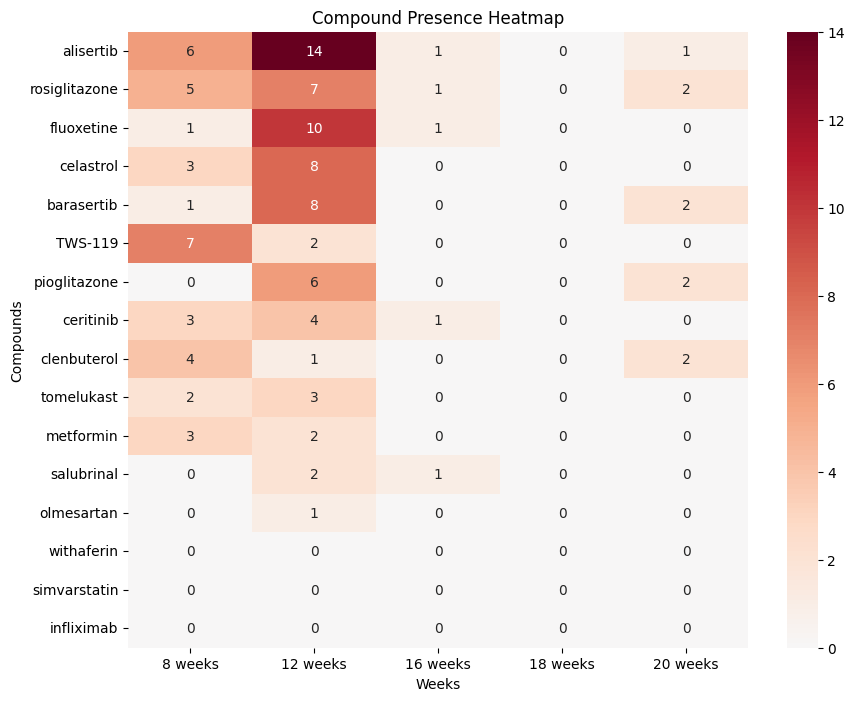

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the list of compounds
compounds_list = ['rosiglitazone', 'fluoxetine', 'alisertib', 'tomelukast', 'celastrol',
                  'pioglitazone', 'TWS-119', 'barasertib', 'clenbuterol', 'withaferin', 'ceritinib', 'olmesartan', 'simvarstatin', 'metformin', 'salubrinal', 'infliximab', 'clenbuterol']

# Define the list columns
list_cols = ['8 weeks', '12 weeks', '16 weeks', '18 weeks', '20 weeks']

# Initialize an empty dictionary to store the data
compound_presence = {compound: {week: 0 for week in list_cols} for compound in compounds_list}

# Populate the dictionary with counts
for compound in compounds_list:
    for week in list_cols:
        compound_presence[compound][week] = df_CMAP[week].tolist().count(compound)

# Convert the dictionary to a DataFrame for better visualization
presence_df = pd.DataFrame(compound_presence).T  # Transpose to get compounds as rows

# Calculate the total presence of each compound across all weeks
presence_df['Total'] = presence_df.sum(axis=1)

# Sort the columns based on the total presence
presence_df = presence_df.sort_values(by='Total', ascending=False)

# Display the table with ranking
print("Ranking of Compounds by Total Presence:")
print(presence_df)

# Remove the 'Total' column for heatmap visualization
presence_df_heatmap = presence_df.drop(columns=['Total'])

# Plot heatmap with reversed colormap and center at zero
plt.figure(figsize=(10, 8))
sns.heatmap(presence_df_heatmap, cmap="RdBu_r", annot=True, fmt="d", center=0)
plt.title('Compound Presence Heatmap')
plt.xlabel('Weeks')
plt.ylabel('Compounds')
plt.show()



In [28]:

# Call the function and get the sorted compounds
compound_info_df, ranks = find_compound_ranks(df_CMAP, list_cols, score_cols, compounds_to_find)

# Create a DataFrame from sorted_compounds
compound_info_df = pd.DataFrame(compound_info_df, columns=['Drug', 'Average_Rank'])

# Now you can use .head() as compound_info_df is a DataFrame
print(compound_info_df.head(15))




             Drug  Average_Rank
0     cariprazine          13.0
1       LY-255283          15.0
2        fraxidin          23.0
3        SA-85377          32.0
4          CCL3L1          33.0
5   thioacetamide          34.0
6      STK-064652          37.0
7         PKI-179          44.0
8          O-2050          65.0
9      ipidacrine          66.0
10   BAS-02859604          76.0
11     PATI-1-2-3          76.0
12  isocarboxazid          82.0
13    florfenicol         148.0
14    ponalrestat         148.0


# Normalise and merge data frames with MPO

In [29]:
# Make drug names in MPO data lower case
df_MPO['Drug'] = df_MPO['Drug'].str.lower()

#Merge aggregated compound ranking information with calcuted MPO data
Average_rank_MPO = pd.merge(compound_info_df, df_MPO, left_on='Drug', right_on='Drug', how='inner')

list_cols = ['8 weeks', '12 weeks', '16 weeks', '18 weeks', '20 weeks']
score_cols = ['NCS', 'NCS.1', 'NCS.2', 'NCS.3', 'NCS.4']
compounds_to_find = ['rosiglitazone', 'fluoxetine', 'alisertib', 'tomelukast', 'celastrol', 'pioglitazone', 'TWS-119', 'barasertib', 'clenbuterol', 'withaferin']

print(Average_rank_MPO.head(25))


                   Drug  Average_Rank  Calculated_MPO      ChEMBL ID  Phase  \
0           cariprazine     13.000000        4.324429  CHEMBL2028019      4   
1         isocarboxazid     82.000000        5.500000  CHEMBL1201168      4   
2            benperidol    491.500000        5.211786   CHEMBL297302      4   
3              tyramine    680.000000        4.670000    CHEMBL11608      3   
4            atazanavir    841.500000        1.625000     CHEMBL1163      4   
5               inosine    905.000000        4.000000     CHEMBL1556      3   
6            amineptine   1049.500000        4.165000   CHEMBL418995      4   
7             camicinal   1108.666667        4.228857   CHEMBL489095      3   
8   dexchlorpheniramine   1368.000000        3.855000  CHEMBL1201353      4   
9             sisomicin   1450.000000        2.579786   CHEMBL221886      3   
10          oxiconazole   1545.666667        3.476714     CHEMBL1262      4   
11           droperidol   1569.000000        5.27114

# Display results

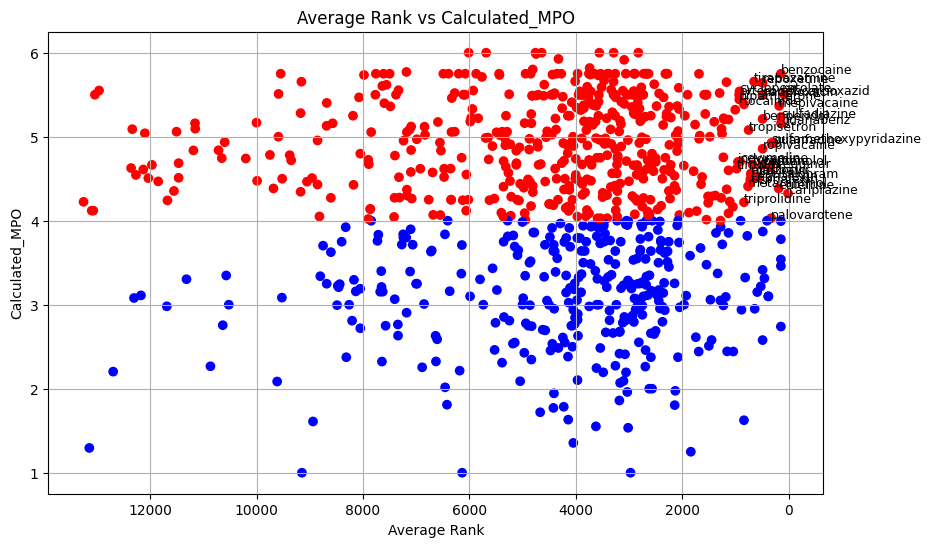

In [30]:
import matplotlib.pyplot as plt

# Assuming compound_info_df is already defined and contains the necessary data
plt.figure(figsize=(10, 6))

# Create a list of colors based on Calculated_MPO values
colors = ['red' if mpo > 4 else 'blue' for mpo in Average_rank_MPO['Calculated_MPO']]

# Scatter plot with specified colors
plt.scatter(Average_rank_MPO['Average_Rank'], Average_rank_MPO['Calculated_MPO'], c=colors)

# Add drug names to specific points
for index, row in Average_rank_MPO.iterrows():
    if row['Calculated_MPO'] > 4 and row['Average_Rank'] < 1000:
        plt.text(row['Average_Rank'], row['Calculated_MPO'], row['Drug'], fontsize=9)

# Invert x-axis to have largest values on the left
plt.gca().invert_xaxis()

# Setting title and labels
plt.title('Average Rank vs Calculated_MPO')
plt.xlabel('Average Rank')
plt.ylabel('Calculated_MPO')
plt.grid(True)
plt.show()

## WHY ARE THEIR RANKS OF 12OOO WHEN THE LARGEST DATA FRAME DOESNT HAVE THIS MANY COMPOUNDS ### 12 WEEKS ACTUALLY HAS 16000 AND IS SKEWING THE DATA

plot volcanos and correlation analysis

KeyError: 'NCS_8_weeks'

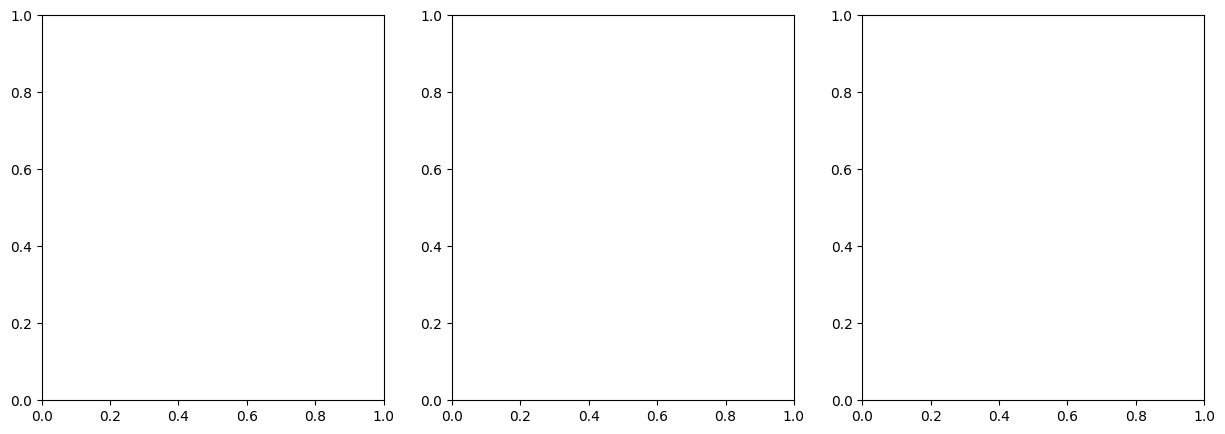

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

df_CMAP = pd.DataFrame(df_CMAP)

# Creating a figure with subplots for each combination of time points
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# 8 weeks vs 12 weeks
axs[0].scatter(df_CMAP['NCS_8_weeks'], df_CMAP['NCS_12_weeks'])
axs[0].set_xlabel('NCS at 8 weeks')
axs[0].set_ylabel('NCS at 12 weeks')
axs[0].set_title('8 weeks vs 12 weeks')

# 8 weeks vs 16 weeks
axs[1].scatter(df_CMAP['NCS_8_weeks'], df_CMAP['NCS_16_weeks'])
axs[1].set_xlabel('NCS at 8 weeks')
axs[1].set_ylabel('NCS at 16 weeks')
axs[1].set_title('8 weeks vs 16 weeks')

# 12 weeks vs 16 weeks
axs[2].scatter(df_CMAP['NCS_12_weeks'], df_CMAP['NCS_16_weeks'])
axs[2].set_xlabel('NCS at 12 weeks')
axs[2].set_ylabel('NCS at 16 weeks')
axs[2].set_title('12 weeks vs 16 weeks')

plt.tight_layout()
plt.show()

df_CMAP(head)

#Jacquard Analysis

In [42]:
# Function to calculate Jaccard similarity
def calculate_jaccard_similarity(series1, series2):
    set1 = set(series1.dropna())
    set2 = set(series2.dropna())
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    if not union:  # Prevent division by zero
        return np.nan
    return len(intersection) / len(union)



In [43]:

# Extract columns
col1 = df_CMAP['8 weeks']
col3 = df_CMAP['12 weeks']
col5 = df_CMAP['16 weeks']
col7 = df_CMAP['18 weeks']
col9 = df_CMAP['20 weeks']

# Calculate Jaccard similarities
similarity_8_12 = calculate_jaccard_similarity(col1, col3)
similarity_8_16 = calculate_jaccard_similarity(col1, col5)
similarity_12_16 = calculate_jaccard_similarity(col3, col5)
similarity_8_18 = calculate_jaccard_similarity(col1, col7)
similarity_8_20 = calculate_jaccard_similarity(col1, col9)
similarity_12_18 = calculate_jaccard_similarity(col3, col7)
similarity_12_20 = calculate_jaccard_similarity(col3, col9)
similarity_16_18 = calculate_jaccard_similarity(col5, col7)
similarity_16_20 = calculate_jaccard_similarity(col5, col9)
similarity_18_20 = calculate_jaccard_similarity(col7, col9)

# Print results
print(f"Jaccard Similarity between Week 8 and Week 12: {similarity_8_12}")
print(f"Jaccard Similarity between Week 8 and Week 16: {similarity_8_16}")
print(f"Jaccard Similarity between Week 12 and Week 16: {similarity_12_16}")
print(f"Jaccard Similarity between Week 8 and Week 18: {similarity_8_18}")
print(f"Jaccard Similarity between Week 8 and Week 20: {similarity_8_20}")
print(f"Jaccard Similarity between Week 12 and Week 18: {similarity_12_18}")
print(f"Jaccard Similarity between Week 12 and Week 20: {similarity_12_20}")
print(f"Jaccard Similarity between Week 16 and Week 18: {similarity_16_18}")
print(f"Jaccard Similarity between Week 16 and Week 20: {similarity_16_20}")
print(f"Jaccard Similarity between Week 18 and Week 20: {similarity_18_20}")


Jaccard Similarity between Week 8 and Week 12: 0.39485087942900843
Jaccard Similarity between Week 8 and Week 16: 0.16097809475292918
Jaccard Similarity between Week 12 and Week 16: 0.11102106969205834
Jaccard Similarity between Week 8 and Week 18: 0.047127468581687613
Jaccard Similarity between Week 8 and Week 20: 0.14194871794871794
Jaccard Similarity between Week 12 and Week 18: 0.04856567689984902
Jaccard Similarity between Week 12 and Week 20: 0.19428755849604648
Jaccard Similarity between Week 16 and Week 18: 0.03727369542066028
Jaccard Similarity between Week 16 and Week 20: 0.053316645807259075
Jaccard Similarity between Week 18 and Week 20: 0.050529948237614


Attempt at weighted similarity

In [44]:
def custom_similarity(df, col_drug1, col_ncs1, col_drug2, col_ncs2):
    # Ensure NCS columns are numeric
    df[col_ncs1] = pd.to_numeric(df[col_ncs1], errors='coerce')
    df[col_ncs2] = pd.to_numeric(df[col_ncs2], errors='coerce')

    # Drop rows where either drug name or NCS is NaN
    df = df.dropna(subset=[col_drug1, col_ncs1, col_drug2, col_ncs2])

    # Creating dictionaries to pair drugs with their NCS values
    drugs_at_time1 = dict(zip(df[col_drug1], df[col_ncs1]))
    drugs_at_time2 = dict(zip(df[col_drug2], df[col_ncs2]))

    # Identifying common and unique drugs
    common_drugs = set(drugs_at_time1.keys()).intersection(set(drugs_at_time2.keys()))
    all_drugs = set(drugs_at_time1.keys()).union(set(drugs_at_time2.keys()))

    # Calculating weighted intersection and union
    intersection = sum(min(drugs_at_time1.get(drug, 0), drugs_at_time2.get(drug, 0)) for drug in all_drugs)
    union = sum(max(drugs_at_time1.get(drug, 0), drugs_at_time2.get(drug, 0)) for drug in all_drugs)

    # Computing similarity
    return intersection / union if union != 0 else 0

# Example usage
similarity_8_12 = custom_similarity(df, '8 weeks', 'NCS', '12 weeks', 'NCS')
similarity_8_16 = custom_similarity(df, '8 weeks', 'NCS', '16 weeks', 'NCS')
similarity_12_16 = custom_similarity(df, '12 weeks', 'NCS', '16 weeks', 'NCS')

print(f"Similarity between Week 8 and Week 12: {similarity_8_12}")
print(f"Similarity between Week 8 and Week 16: {similarity_8_16}")
print(f"Similarity between Week 12 and Week 16: {similarity_12_16}")



NameError: name 'df' is not defined

Unclear how to interpret these data and also expecting 0-1 range